In [1]:
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Dense, Activation, Dropout, Flatten

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import matplotlib.pyplot as plt

C:\Users\user\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#cpu - gpu configuration
config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': 56} ) #max: 1 gpu, 56 cpu
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

In [2]:
#variables
num_classes = 7 #angry, disgust, fear, happy, sad, surprise, neutral
batch_size = 256
epochs = 10

In [3]:
with open(r"C:\Users\user\Desktop\Hiring Hackathon\data\fer2013\fer2013.csv") as f:
    content = f.readlines()

lines = np.array(content)

num_of_instances = lines.size
print("number of instances: ",num_of_instances)
print("instance length: ",len(lines[1].split(",")[1].split(" ")))

number of instances:  35888
instance length:  2304


In [4]:
#initialize trainset and test set
x_train, y_train, x_test, y_test = [], [], [], []

In [5]:
#transfer train and test set data
for i in range(1,num_of_instances):
    try:
        emotion, img, usage = lines[i].split(",")
          
        val = img.split(" ")
            
        pixels = np.array(val, 'float32')
        
        emotion = keras.utils.to_categorical(emotion, num_classes)
    
        if 'Training' in usage:
            y_train.append(emotion)
            x_train.append(pixels)
        elif 'PublicTest' in usage:
            y_test.append(emotion)
            x_test.append(pixels)
    except:
        print("",end="")

In [6]:
#data transformation for train and test sets
x_train = np.array(x_train, 'float32')
y_train = np.array(y_train, 'float32')
x_test = np.array(x_test, 'float32')
y_test = np.array(y_test, 'float32')

x_train /= 255 #normalize inputs between [0, 1]
x_test /= 255

x_train = x_train.reshape(x_train.shape[0], 48, 48, 1)
x_train = x_train.astype('float32')
x_test = x_test.reshape(x_test.shape[0], 48, 48, 1)
x_test = x_test.astype('float32')

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

28709 train samples
3589 test samples


In [7]:
#construct CNN structure
model = Sequential()

#1st convolution layer
model.add(Conv2D(64, (5, 5), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(5,5), strides=(2, 2)))

#2nd convolution layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

#3rd convolution layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(3,3), strides=(2, 2)))

model.add(Flatten())

#fully connected neural networks
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

In [8]:
#batch process
gen = ImageDataGenerator()
train_generator = gen.flow(x_train, y_train, batch_size=batch_size)

In [9]:
model.compile(loss='categorical_crossentropy'
    , optimizer=keras.optimizers.Adam()
    , metrics=['accuracy']
)

In [10]:
fit = True

if fit == True:
    #model.fit_generator(x_train, y_train, epochs=epochs) #train for all trainset
    model.fit_generator(train_generator, steps_per_epoch=batch_size, epochs=epochs) #train for randomly selected one
else:
    model.load_weights('/data/facial_expression_model_weights.h5') #load weights

Epoch 1/10
256/256 [==============================] - 3472s 14s/step - loss: 1.7830 - acc: 0.2618
Epoch 2/10
256/256 [==============================] - 3124s 12s/step - loss: 1.5331 - acc: 0.3983
Epoch 3/10
256/256 [==============================] - 7534s 29s/step - loss: 1.3594 - acc: 0.4779
Epoch 4/10
256/256 [==============================] - 2827s 11s/step - loss: 1.2576 - acc: 0.5210
Epoch 5/10
256/256 [==============================] - 2705s 11s/step - loss: 1.1737 - acc: 0.5548
Epoch 6/10
256/256 [==============================] - 2706s 11s/step - loss: 1.1126 - acc: 0.5810
Epoch 7/10
256/256 [==============================] - 2705s 11s/step - loss: 1.0573 - acc: 0.6029
Epoch 8/10
256/256 [==============================] - 3179s 12s/step - loss: 0.9908 - acc: 0.6273
Epoch 9/10
256/256 [==============================] - 2989s 12s/step - loss: 0.9340 - acc: 0.6511
Epoch 10/10
256/256 [==============================] - 2620s 10s/step - loss: 0.8746 - acc: 0.6753


In [11]:
train_score = model.evaluate(x_train, y_train, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])
 
test_score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

Train loss: 0.789888549766187
Train accuracy: 70.83492981336587
Test loss: 1.266455175950355
Test accuracy: 55.39147394900535


In [12]:
#function for drawing bar chart for emotion preditions
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
    plt.show()

In [13]:
model.save("fec.h5")

In [14]:
monitor_testset_results = False

if monitor_testset_results == True:
    #make predictions for test set
    predictions = model.predict(x_test)

    index = 0
    for i in predictions:
        if index < 30 and index >= 20:
            #print(i) #predicted scores
            #print(y_test[index]) #actual scores
            
            testing_img = np.array(x_test[index], 'float32')
            testing_img = testing_img.reshape([48, 48]);
            
            plt.gray()
            plt.imshow(testing_img)
            plt.show()
            
            print(i)
            
            emotion_analysis(i)
            print("----------------------------------------------")
        index = index + 1

C:\Users\user\Anaconda3\lib\site-packages\keras_preprocessing\image\utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


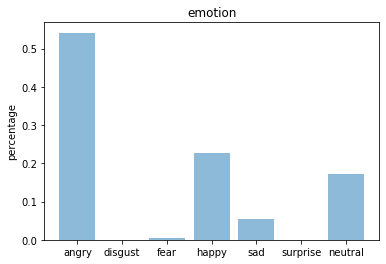

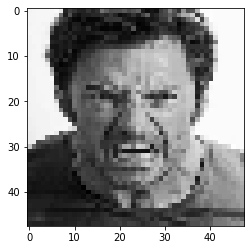

In [20]:
#make prediction for custom image out of test set

img = image.load_img(r"C:\Users\user\Desktop\Hiring Hackathon\jackman1.jpg", grayscale=True, target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = model.predict(x)
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48]);

plt.gray()
plt.imshow(x)
plt.show()